**Importing packages that we need**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize
import time

**Setting up the Monte Carlo method for a NxN lattice:**

In [2]:
#function that defines that inital state for the lattice calling a random number generator
@jit()
def StateInitalize(N):
    #NXN number of spins
    Lattice = np.zeros((N,N))
    for i in range(N):
        for l in range(N):
            randNum = np.random.random()
            if randNum < 0.5:
                Lattice[i,l] = int(-1)
            else:
                Lattice[i,l] = int(1)
                
    return Lattice

**NeigbourInteraction is a function that calculates the change in energy upon flipping one spin:**

In [3]:
@jit()
def NeigbourInteraction(line,column,InitialState,LatticeSize):
    M = LatticeSize
    DeltaE = 0
    if line == int(0):#if at the top edge of lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line+1,column]#below
    if line == int((M-1)):#if at the bottom edge lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line-1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below
    #Then check if at left or right edges or inside
    else:
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below

    DeltaE = -(Temp1 + Temp2 + Temp3 + Temp4)
    DeltaE = DeltaE*2
    #print("DeltaE is:",DeltaE)
    return DeltaE

**Function that calculates the Magnetization:**

In [4]:
@jit()
def Magnetization(Lattice):
    N,M = np.shape(Lattice)
    Magnetization = 0
    for i in range(M):#looping over lines
        for j in range(M):#looping over colums
            Magnetization += Lattice[i,j]#Adding the spin value at location i,j
            
    return Magnetization

In [5]:
#Trial of Magnetization function
LatticeA = np.array([[1,-1],[1,1]])
Magn = Magnetization(LatticeA)
print(Magn)

2


**Calculating the energy of the lattice according to the Ising model with periodic boundary conditions:**

In [6]:
@jit()
def LatticeEnergyIsing(InitialState,LatticeSize):
    #M = LatticeSize
    N,M = np.shape(InitialState)
    Energy = 0
    #print("Inital Energy:",Energy)
    for i in range(M):#loop over lines
        for j in range(M):#loop over columns
            Acceptance = (np.mod(i,2)+np.mod(j,2) == 0) or (np.mod(i,2)+np.mod(j,2) == 2)
            #print(Acceptance)
            if Acceptance:
                if (i == 0 and j == 0):#if at the top and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == 0 and j == (M-1)):#if at the top and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == 0):#if at the bottom and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == (M-1)):#if at the bottom and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == 0:#if only at top edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == (M-1):#if only at bottom edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == 0:#if only at left edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == (M-1):#if only at right edge
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                else:#if somewhere in the middle
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                
    return Energy

In [7]:
#Trial of energy
B = np.array([[1,1],[1,1]])
print(B)
EnergyTrial = LatticeEnergyIsing(B,2)
print("The energy according to Ising Model:", EnergyTrial)

[[1 1]
 [1 1]]
The energy according to Ising Model: -8


**Metropolis part:**

In [8]:
@jit()
def Metropolis(DeltaEnergy,Temperature):
    Accept = False
    Exp1 = np.exp(-(1/Temperature)*(-8))
    Exp2 = np.exp(-(1/Temperature)*(-4))
    Exp3 = 1
    Exp4 = np.exp(-(1/Temperature)*(4))
    Exp5 = np.exp(-(1/Temperature)*(8))
    if DeltaEnergy < 0:
        Accept = True
    else:
        randNum = np.random.random()
        if DeltaEnergy == -8:
            w = Exp1
        elif DeltaEnergy == -4:
            w = Exp2
        elif DeltaEnergy == 0:
            w = Exp3
        elif DeltaEnergy == 4:
            w = Exp4
        else:
            w = Exp5
        #Checking w agains the exponent and accepting if r <= w
        if randNum <= w:
            Accept = True
        else:
            Accept = False
            
    return Accept

**The Monte Carlo calculation itself:**

In [27]:
@jit()
def MonteCarloIsing(InitialState1,NumOfCycles,LatticeSize,Temperature):
    EnergyVector = np.zeros(NumOfCycles-80001)
    MagnetizationVector = np.zeros(NumOfCycles-80001)
    T = Temperature
    M = LatticeSize
    NSpins = M*M#Number of spins
    EnergyMatrix = InitialState1
    InitialState = InitialState1#Setting a lattice for overwriting
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(EnergyMatrix,M)
    #print(Energy)
    MC = NumOfCycles
    CounterAcceptance = 0#Counter to see how many moves are accepted
    EnergyValue = 0
    EnergyValueSquared = 0
    MagnValue = 0
    MagnValueSquared = 0
    MagnValueAbs = 0
    norm = 1/MC
    counter = 0
    for i in range(MC):#Looping over the number of MC cycles
        #picking a random coordinate in the lattice
        randNum = np.random.randint(M*M)
        line = int(np.floor(randNum/M))#finding the relavant line in the lattice
        column = int(randNum - M*line)#finding the relavant column in the lattice
        #print(randNum,line,column)
        #flipping the spin at that position
        TempState = InitialState.copy()
        #print(InitialState[line,column])
        #print(InitialState)
        if InitialState[line,column] == 1:
            TempState[line,column] = int(-1)
            tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
        else:
            TempState[line,column] = int(1)
            tempValue = int(1)#setting temp value to the assign to the system if move is accepted
        #finding the difference in energy - using periodic boundary conditions
        DeltaE = NeigbourInteraction(line,column,TempState,M)
        Acceptance = Metropolis(DeltaE,T)
        #Metropolis part
        if Acceptance:
            InitialState[line,column] = tempValue
            CounterAcceptance += 1  
        #Appending Energy and other relevant variables for calculations
        Energy = LatticeEnergyIsing(InitialState,M)#Þarf að taka alltaf gildin á orkunni!!!
        if i > 80000:#Accounting for time that it takes to reach the most likely state
            EnergyVector[counter] = Energy
            EnergyValue += Energy
            EnergyValueSquared += Energy**2
            #Magnetization
            MagnetiZ = Magnetization(InitialState)
            MagnetizationVector[counter] = MagnetiZ
            MagnValue += MagnetiZ
            MagnValueSquared += MagnetiZ**2
            MagnValueAbs += abs(MagnetiZ)
            counter += 1
        #End of MC loop

    #print(InitialState)
    #print(Energy)
    FinalEnergy = LatticeEnergyIsing(InitialState,M)
    #Calculating average energy per particle
    TotalEnergy = sum(EnergyVector)
    AverageEnergy = EnergyValue/MC
    AverageEnergySquared = EnergyValueSquared/MC
    #Energy per spin
    EnergyPerParticle = AverageEnergy/NSpins
    #Variance in Energy
    EnergyVariancePerSpin = (AverageEnergySquared - AverageEnergy**2)/NSpins
    #Specific Heat - SPURNING hvað ég að nota fyrir Boltzmanns fasta
    k = 1
    SpecificHeat = (1/(k*(T**2)))*EnergyVariancePerSpin
    #Magnetization
    AverageMagnetization = MagnValue/MC
    AverageMagnetizationPerPar = AverageMagnetization/NSpins
    AverageMagnetizationSquared = MagnValueSquared/MC
    AverageMagnetizationAbs = MagnValueAbs/MC
    AverageMagnetizationAbsPerSpin = AverageMagnetizationAbs/NSpins
    #Variance in Magnetization
    MagnetizationVariancePerSpin = (AverageMagnetizationSquared - AverageMagnetization**2)/(NSpins)
    #Susceptibility
    Susceptibility = (1/(k*T))*MagnetizationVariancePerSpin

    return CounterAcceptance, EnergyVector, EnergyPerParticle, AverageMagnetizationPerPar, AverageMagnetizationAbsPerSpin, SpecificHeat, Susceptibility

**Trying the algo:**
Gera 2x2 case þannig að ég tel frá byrjun!!!

In [29]:
A = StateInitalize(2)
start = time.time()
AcceptedMoves, EnergyAll, EnergyPerPart, AverageMagn, AverageMagnAbs, SpecificHeat, Susceptibility = MonteCarloIsing(A,1000000,2,1)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves)
print("Energy per particle:",EnergyPerPart)
print("The Average magnetization per spin is:",AverageMagn)
print("The Average absolute magnetization per spin is",AverageMagnAbs)
print("The Specific Heat is:",SpecificHeat)
print("The Susceptibility is:",Susceptibility)#Susceptibility measurement looks strange!!

The measurement took, in seconds: 0.31778454780578613
Number of Accepted moves: 1977
Energy per particle: -1.83633
The Average magnetization per spin is: 0.010888
The Average absolute magnetization per spin is 0.91878
The Specific Heat is: 1.2022085243999996
The Susceptibility is: 3.6734158058240003


**Plotting the energy as a function of MC steps:**

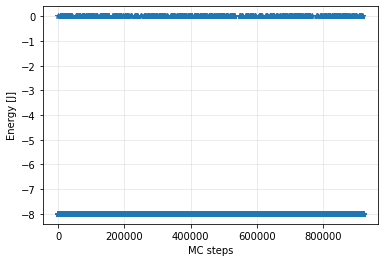

In [30]:
fig, ax = plt.subplots()
Steps = np.arange(0,1000000-80001)
ax.plot(Steps,EnergyAll,'*')
ax.set_xlabel("MC steps")
ax.set_ylabel("Energy [J]")
ax.grid(alpha=0.3)
plt.show()

**Trial for bigger lattice:**

In [31]:
A2 = StateInitalize(20)
start = time.time()
AcceptedMoves2, EnergyAll2, EnergyPerPart2, AverageMagn2, AverageMagnAbs2,SpecificHeat2, Susceptibility2 = MonteCarloIsing(A2,1000000,20,2)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves2)
print("Energy per particle:",EnergyPerPart2)
print("The Average magnetization is:",AverageMagn2)
print("The Averaga absolute magnetization is:",AverageMagnAbs2)
print("The Specific Heat is:",SpecificHeat2)
print("The Susceptibility is:", Susceptibility2)

The measurement took, in seconds: 2.418663740158081
Number of Accepted moves: 93449
Energy per particle: -1.5850482049999999
The Average magnetization is: -0.781104055
The Averaga absolute magnetization is: 0.783482635
The Specific Heat is: 22.656189855127813
The Susceptibility is: 16.530742077511405


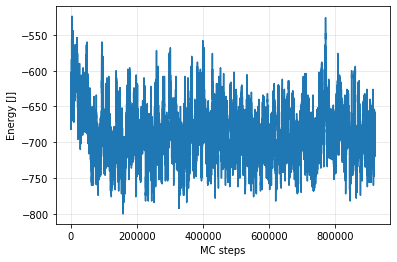

In [32]:
fig2, ax2 = plt.subplots()
Steps2 = np.arange(0,1000000-80001)
ax2.plot(Steps2,EnergyAll2)
ax2.set_xlabel("MC steps")
ax2.set_ylabel("Energy [J]")
ax2.grid(alpha=0.3)#Eitthvað abnormalitiy í lokin!!!
plt.show()

**We see that the system has reached its most likely state after at least 80000 iterations, but often quite lower. Thus we start to take measurements after 80000 iterations for analysis.**

**Let's do measurements for several different Temperature:**

2.2357308864593506
2.4540035724639893
2.2854816913604736
2.281118869781494
2.3298134803771973
2.481330394744873
2.6364986896514893
2.523759126663208
2.397557497024536
2.300330638885498
2.336735963821411
2.3269824981689453
2.3041276931762695
2.5073747634887695
2.401089906692505
2.4121439456939697


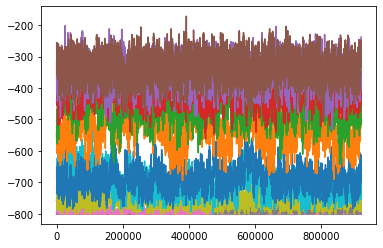

In [40]:
T = [0.1,0.3,0.5,0.7,0.9,1,1.3,1.5,1.7,1.9,2,2.3,2.5,2.7,2.9,3]
MC_Cycles = int(1e6)
Steps3 = np.arange(0,MC_Cycles-80001)
AcceptedMoves = np.zeros(len(T))
EnergyPerParticle = np.zeros(len(T))
MagnetizationPerParticle = np.zeros(len(T))
Susceptibility = np.zeros(len(T))
SpecificHeat = np.zeros(len(T))
fig3, ax3 = plt.subplots()
counter = 0
for Temp in T:
    A3 = StateInitalize(20)
    start = time.time()
    AcceptedMoves2, EnergyAll2, EnergyPerPart2, AverageMagn2, AverageMagnAbs2,SpecificHeat2, Susceptibility2 = MonteCarloIsing(A3,MC_Cycles,20,Temp)
    end = time.time()
    print(end-start)
    EnergyPerParticle[counter] = EnergyPerPart2
    SpecificHeat[counter] = SpecificHeat2
    MagnetizationPerParticle[counter] = AverageMagnAbs2
    Susceptibility[counter] = Susceptibility2
    counter += 1
    ax3.plot(Steps3,EnergyAll2)
    
plt.show()

**Energy per particle as a function of temperature:**

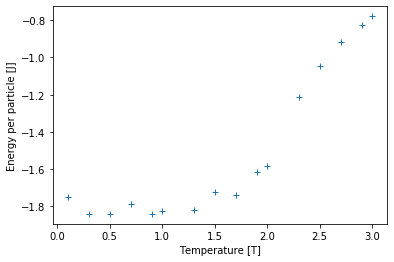

In [41]:
#Plotting energy as a function of particle
fig4,ax4 = plt.subplots()
ax4.plot(T,EnergyPerParticle,'+')
ax4.set_ylabel("Energy per particle [J]")
ax4.set_xlabel("Temperature [T]")
plt.show()

**Specific heat as a function of temperature:**

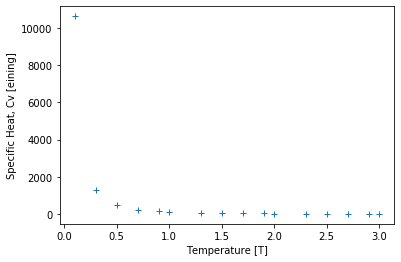

In [42]:
#Plotting specific heat as a function of Temperature - Eitthvað mjög flippað í gangi hér !!
fig5,ax5 = plt.subplots()
ax5.plot(T,SpecificHeat,'+')
ax5.set_ylabel("Specific Heat, Cv [eining]")
ax5.set_xlabel("Temperature [T]")
plt.show()

**Average Magnetization as a function of particle:**

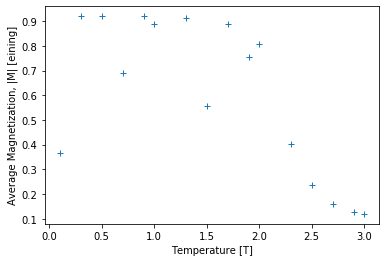

In [43]:
#Plotting average Magnetization as a function of temperature
fig6,ax6 = plt.subplots()
ax6.plot(T,MagnetizationPerParticle,'+')
ax6.set_ylabel("Average Magnetization, |M| [eining]")
ax6.set_xlabel("Temperature [T]")
plt.show()